### 读取mllm模型在某个数据集上被抽取的所有`image_embeds`和`text_embeds`

In [1]:
import torch
from tqdm import tqdm
from utils.metrics import id_correlation
from utils.intrinsic_dimension import estimate_id
import logging
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple

# 绘图库
from matplotlib import pyplot as plt
import numpy as np

In [2]:
id_alg='twoNN'
device='cuda' if torch.cuda.is_available() else 'cpu'
logger = logging.getLogger(__name__)
logging.basicConfig(
    format="%(asctime)s %(levelname)s [%(name)s] %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)

#### 载入`alpha_qwen2.5_3B_Instruct_clipvL14_model`在数据集`LLaVA-CC3M-Pretrain-595K`上计算抽取的`image_embeds`和`text_embeds`每个batch的corr

In [3]:
text_reps = torch.load('./representation/LLaVA-CC3M-Pretrain-595K/alpha_qwen2.5_3B_Instruct_clipvL14_model_text.pt')
image_reps = torch.load('./representation/LLaVA-CC3M-Pretrain-595K/alpha_qwen2.5_3B_Instruct_clipvL14_model_image.pt')
text_reps.shape, image_reps.shape

(torch.Size([595375, 768]), torch.Size([595375, 2048]))

In [4]:
batch_size = 256
# 使用 torch.split 分割张量
text_reps_batches = torch.split(text_reps, batch_size)
image_reps_batches = torch.split(image_reps, batch_size)

In [5]:
text_id_list = []
image_id_list = []
idcor_list = []
p_list = []
merge_id_list = []

# 以batch_size为一批的大小，计算text_embeds与image_embeds之间的corr
for batch, (text_embeds, image_embeds) in tqdm(enumerate(zip(text_reps_batches, image_reps_batches))):
    corr = id_correlation(text_embeds.to(torch.float32), image_embeds.to(torch.float32), 100, id_alg)
    text_id_list.append(corr['id1'])
    image_id_list.append(corr['id2'])
    idcor_list.append(corr['corr'])
    p_list.append(corr['p'])
    merge_id_list.append(corr['id'])

2326it [05:34,  6.96it/s]


#### 绘制柱状图查看`idcor`, `text_id`, `image_id`, `pvalues`, `merge_id`的分布

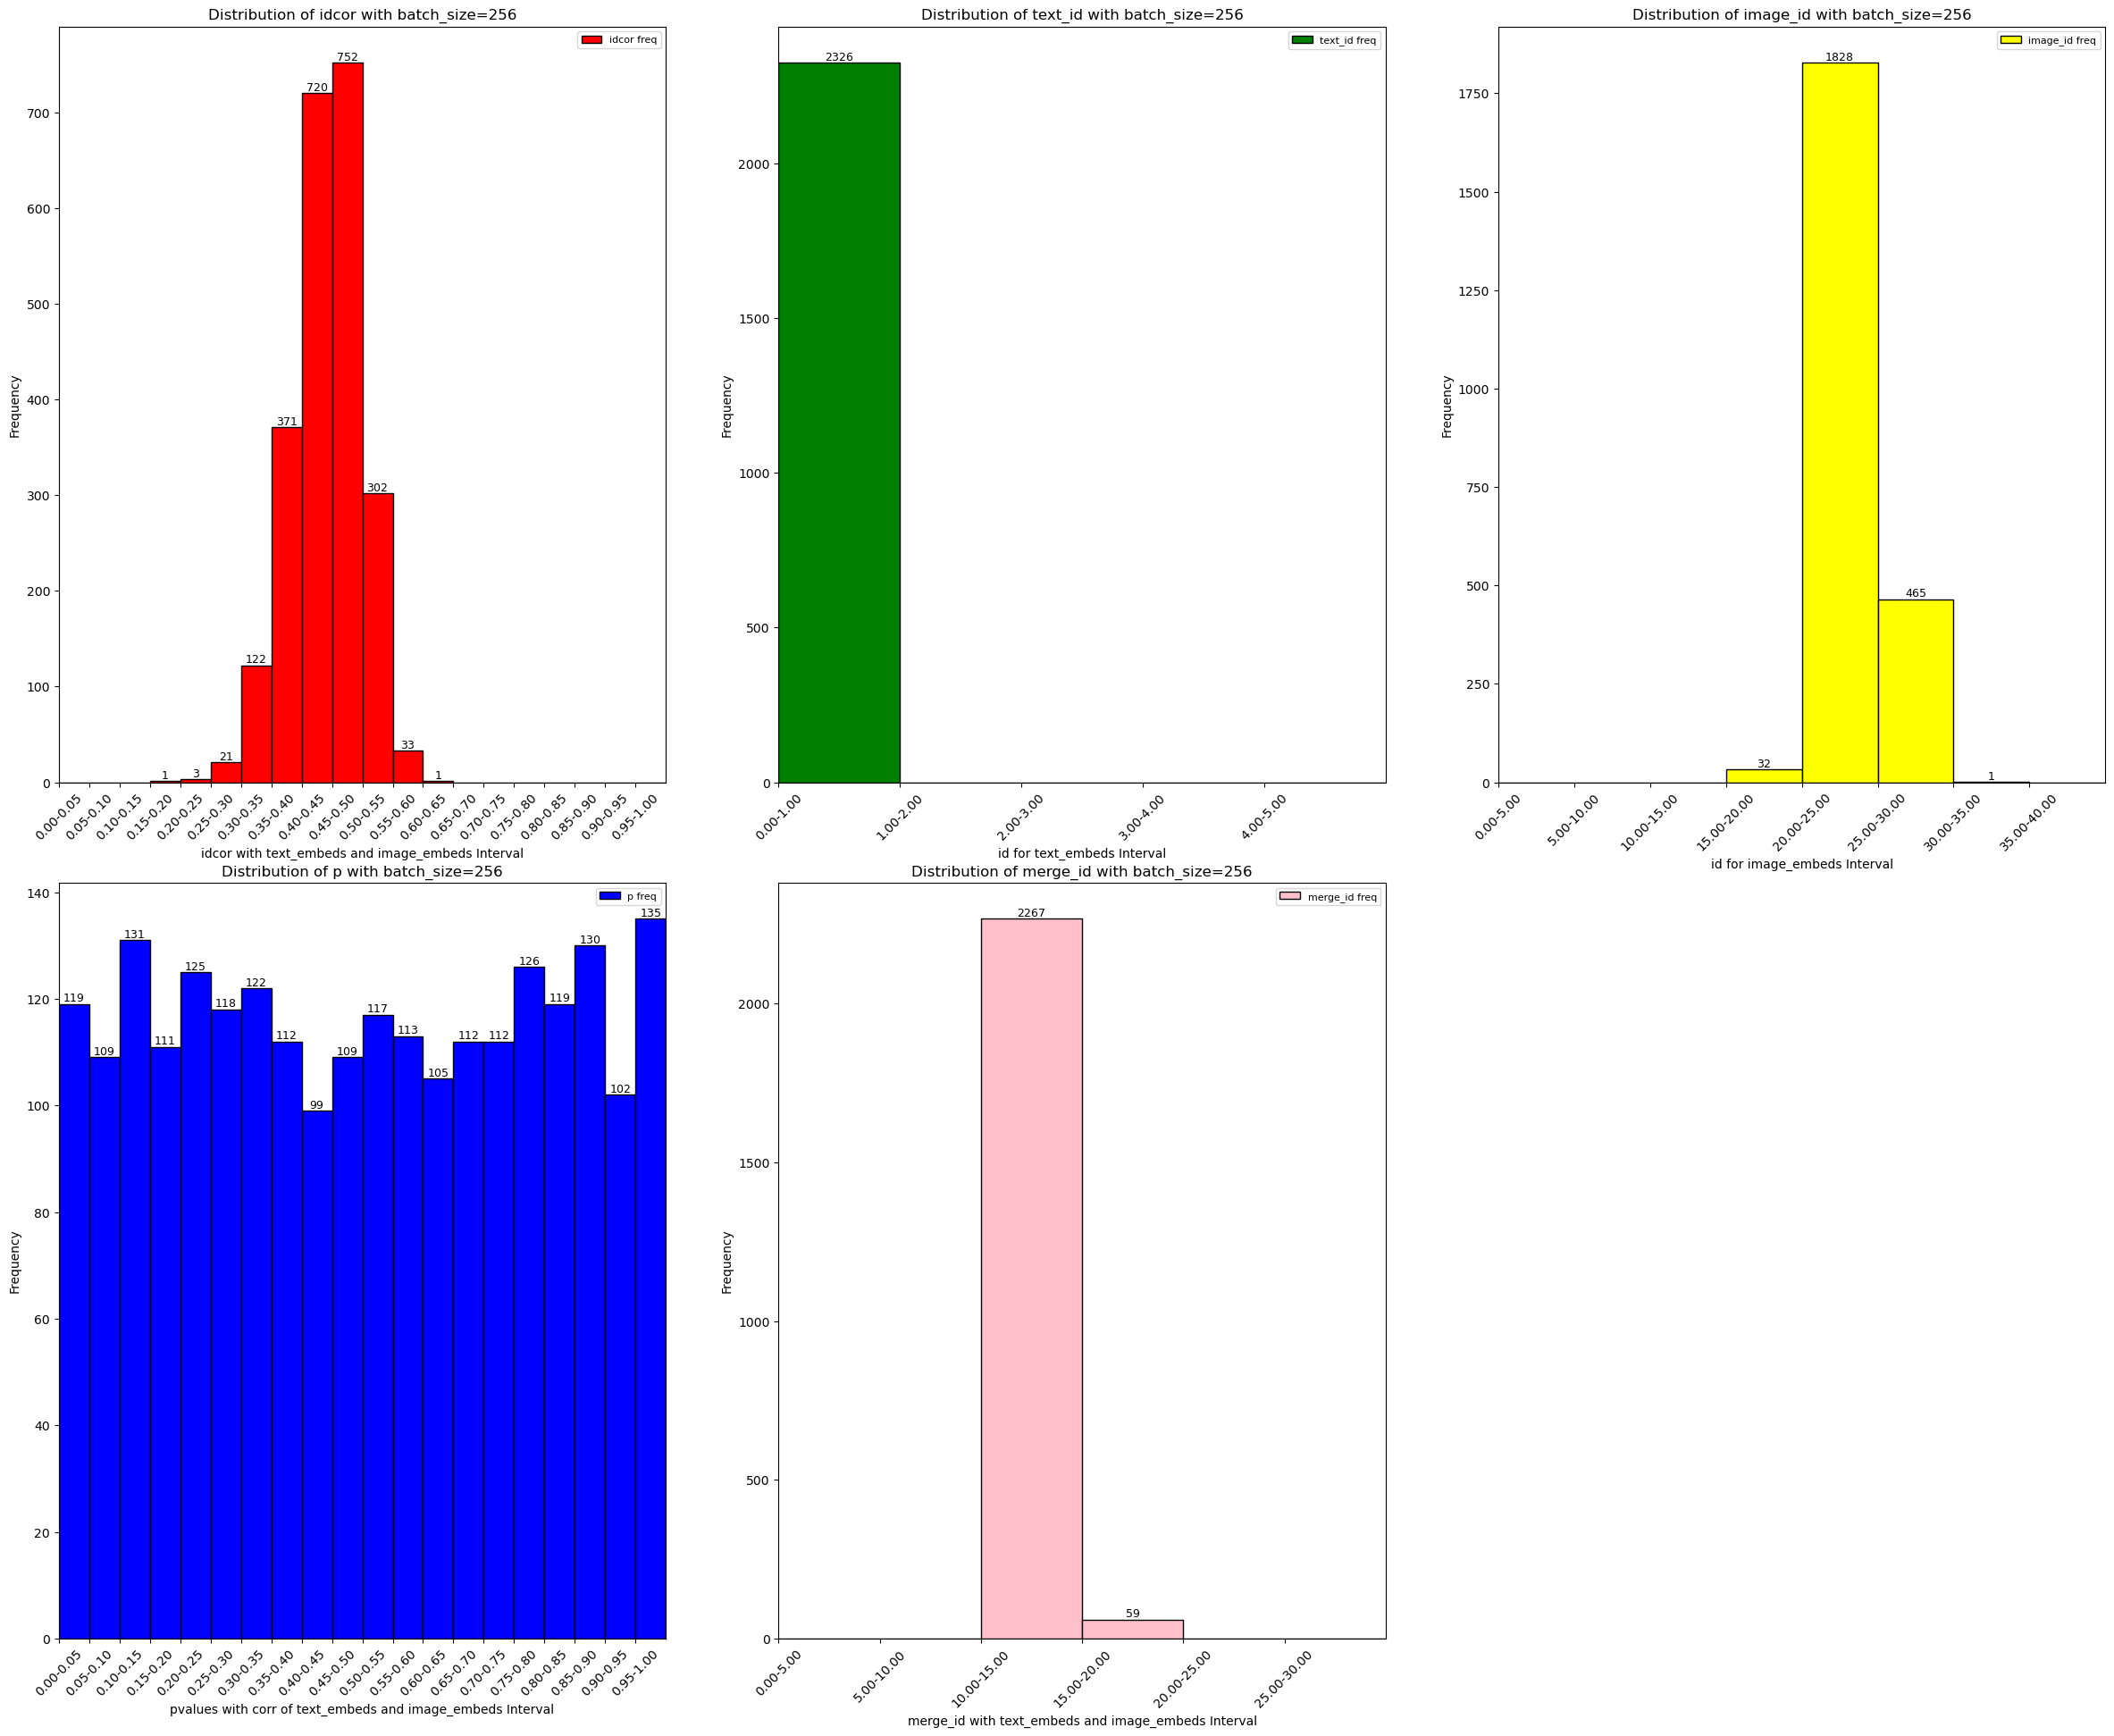

In [42]:
fig, axs = plt.subplots(2, 3, figsize=(25, 20))  # 创建一个包含 2 行 3 列子图的图形
fig.tight_layout(pad=6.0)  # 子图之间的间距

bin_start_list = [0.0, 0.0, 0.0, 0.0, 0.0]
bin_end_list = [1.0, 5.0, 40.0 ,1.0, 30.0]
bin_width_list = [0.05, 1.0, 5.0, 0.05, 5.0]
data_list = [idcor_list, text_id_list, image_id_list, p_list, merge_id_list]
name_list = ['idcor', 'text_id', 'image_id', 'p', 'merge_id']
color_list = ['red', 'green', 'yellow', 'blue', 'pink']
xlabel_list = [
    'idcor with text_embeds and image_embeds Interval',
    'id for text_embeds Interval',
    'id for image_embeds Interval',
    'pvalues with corr of text_embeds and image_embeds Interval',
    'merge_id with text_embeds and image_embeds Interval'
]

for i, ax in enumerate(axs.flat):  # axs.flat 会将二维子图展平，便于迭代
    if i < len(data_list):
        bins = np.arange(bin_start_list[i], bin_end_list[i] + bin_width_list[i], bin_width_list[i])  # 使用numpy的histogram函数来分割数据
        hist, bin_edges = np.histogram(data_list[i], bins=bins)
        
        # 绘制柱状图
        ax.bar(bin_edges[:-1], hist, width=bin_width_list[i], align='edge', edgecolor='black', color=color_list[i])
        
        # 设置标签
        ax.set_xlabel(xlabel_list[i])
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of {name_list[i]} with batch_size={batch_size}')
        
        xScale = [f'{bin_edges[j]:.2f}-{bin_edges[j+1]:.2f}' for j in range(len(bin_edges)-1)]  # 设置x轴刻度
        ax.set_xticks(bin_edges[:-1])
        ax.set_xticklabels(xScale, rotation=45)  # 将标签旋转45度，防止重叠
        ax.set_xlim(bin_edges[0], bin_edges[-1])  # 设置x轴的范围
        
        # 在每个柱子上方显示频率数值
        for j in range(len(hist)):
            if hist[j] > 0:  # 只对频率大于0的柱子标识
                ax.text(bin_edges[j] + bin_width_list[i] / 2, hist[j], str(hist[j]), ha='center', va='bottom', fontsize=9, color='black')
        
        ax.legend([f'{name_list[i]} freq'], loc='upper right', fontsize=8)  # 添加图例

fig.delaxes(axs[1, 2])  # 删除右下角的空白子图
plt.show()

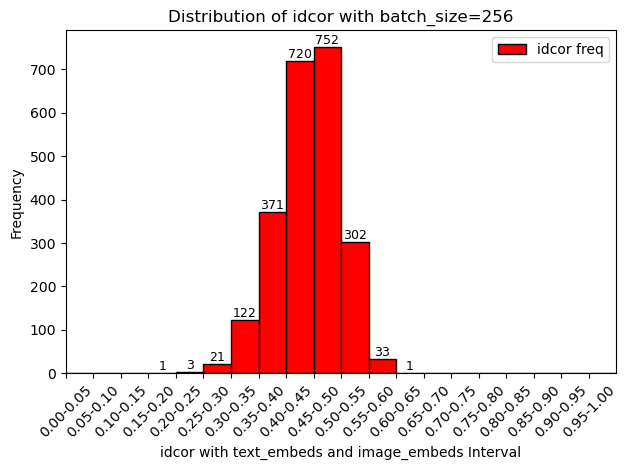

In [20]:
# 设置区间范围
bin_start = 0.0  # 起始区间
bin_end = 1.0    # 结束区间
bin_width = 0.05 # 区间宽度

# 使用numpy的histogram函数来分割数据
bins = np.arange(bin_start, bin_end + bin_width, bin_width)  # 创建一个区间范围
hist, bin_edges = np.histogram(idcor_list, bins=bins)

# 绘制柱状图
plt.bar(bin_edges[:-1], hist, width=bin_width, align='edge', edgecolor='black', color='red')

# 设置标签
plt.xlabel('idcor with text_embeds and image_embeds Interval')
plt.ylabel('Frequency')
plt.title('Distribution of idcor with batch_size=256')

xScale = [f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}' for i in range(len(bin_edges)-1)]  # 设置x轴刻度
plt.xticks(bin_edges[:-1], xScale, rotation=45)  # 将标签旋转45度，防止重叠
plt.xlim(bin_edges[0], bin_edges[-1])  # 设置x轴的范围
# 在每个柱子上方显示频率数值
for i in range(len(hist)):
    if hist[i] > 0:  # 只对频率大于0的柱子标识
        plt.text(bin_edges[i] + bin_width / 2, hist[i], str(hist[i]), ha='center', va='bottom', fontsize=9, color='black')

# 添加图例
plt.legend(['idcor freq'], loc='upper right', fontsize=10)  # 在右上角添加图例

plt.tight_layout()  # 调整布局，防止标签被截断
plt.show()

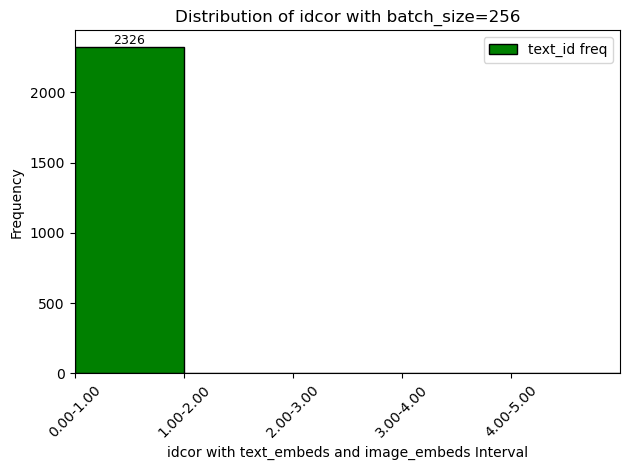

In [25]:
bin_start = 0.0  # 起始区间
bin_end = 5.0    # 结束区间
bin_width = 1.0 # 区间宽度

bins = np.arange(bin_start, bin_end + bin_width, bin_width)  # 创建一个区间范围
hist, bin_edges = np.histogram(text_id_list, bins=bins) # 使用numpy的histogram函数来分割数据

# 绘制柱状图
plt.bar(bin_edges[:-1], hist, width=bin_width, align='edge', edgecolor='black', color='green')

# 设置标签
plt.xlabel('idcor with text_embeds and image_embeds Interval')
plt.ylabel('Frequency')
plt.title('Distribution of idcor with batch_size=256')

xScale = [f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}' for i in range(len(bin_edges)-1)]  # 设置x轴刻度
plt.xticks(bin_edges[:-1], xScale, rotation=45)  # 将标签旋转45度，防止重叠
plt.xlim(bin_edges[0], bin_edges[-1])  # 设置x轴的范围
# 在每个柱子上方显示频率数值
for i in range(len(hist)):
    if hist[i] > 0:  # 只对频率大于0的柱子标识
        plt.text(bin_edges[i] + bin_width / 2, hist[i], str(hist[i]), ha='center', va='bottom', fontsize=9, color='black')

# 添加图例
plt.legend(['text_id freq'], loc='upper right', fontsize=10)  # 在右上角添加图例

plt.tight_layout()  # 调整布局，防止标签被截断
plt.show()

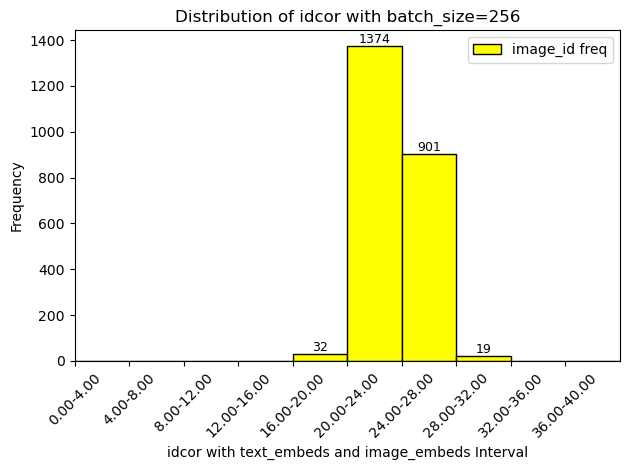

In [30]:
bin_start = 0.0  # 起始区间
bin_end = 40    # 结束区间
bin_width = 4 # 区间宽度

bins = np.arange(bin_start, bin_end + bin_width, bin_width)  # 创建一个区间范围
hist, bin_edges = np.histogram(image_id_list, bins=bins) # 使用numpy的histogram函数来分割数据

# 绘制柱状图
plt.bar(bin_edges[:-1], hist, width=bin_width, align='edge', edgecolor='black', color='yellow')

# 设置标签
plt.xlabel('idcor with text_embeds and image_embeds Interval')
plt.ylabel('Frequency')
plt.title('Distribution of idcor with batch_size=256')

xScale = [f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}' for i in range(len(bin_edges)-1)]  # 设置x轴刻度
plt.xticks(bin_edges[:-1], xScale, rotation=45)  # 将标签旋转45度，防止重叠
plt.xlim(bin_edges[0], bin_edges[-1])  # 设置x轴的范围
# 在每个柱子上方显示频率数值
for i in range(len(hist)):
    if hist[i] > 0:  # 只对频率大于0的柱子标识
        plt.text(bin_edges[i] + bin_width / 2, hist[i], str(hist[i]), ha='center', va='bottom', fontsize=9, color='black')

# 添加图例
plt.legend(['image_id freq'], loc='upper right', fontsize=10)  # 在右上角添加图例

plt.tight_layout()  # 调整布局，防止标签被截断
plt.show()

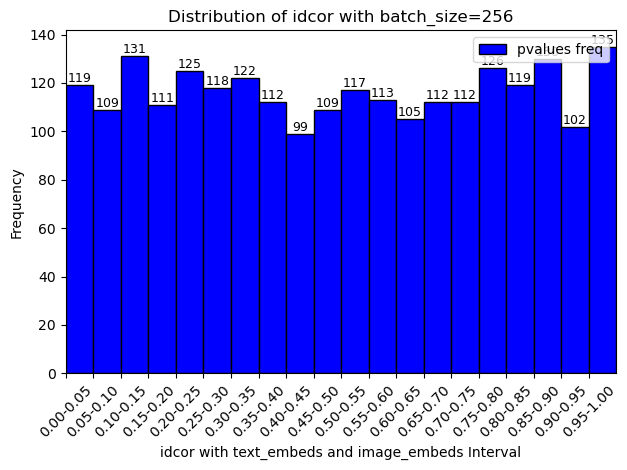

In [31]:
bin_start = 0.0  # 起始区间
bin_end = 1.0    # 结束区间
bin_width = 0.05 # 区间宽度

bins = np.arange(bin_start, bin_end + bin_width, bin_width)  # 创建一个区间范围
hist, bin_edges = np.histogram(p_list, bins=bins) # 使用numpy的histogram函数来分割数据

# 绘制柱状图
plt.bar(bin_edges[:-1], hist, width=bin_width, align='edge', edgecolor='black', color='blue')

# 设置标签
plt.xlabel('idcor with text_embeds and image_embeds Interval')
plt.ylabel('Frequency')
plt.title('Distribution of idcor with batch_size=256')

xScale = [f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}' for i in range(len(bin_edges)-1)]  # 设置x轴刻度
plt.xticks(bin_edges[:-1], xScale, rotation=45)  # 将标签旋转45度，防止重叠
plt.xlim(bin_edges[0], bin_edges[-1])  # 设置x轴的范围
# 在每个柱子上方显示频率数值
for i in range(len(hist)):
    if hist[i] > 0:  # 只对频率大于0的柱子标识
        plt.text(bin_edges[i] + bin_width / 2, hist[i], str(hist[i]), ha='center', va='bottom', fontsize=9, color='black')

# 添加图例
plt.legend(['pvalues freq'], loc='upper right', fontsize=10)  # 在右上角添加图例

plt.tight_layout()  # 调整布局，防止标签被截断
plt.show()

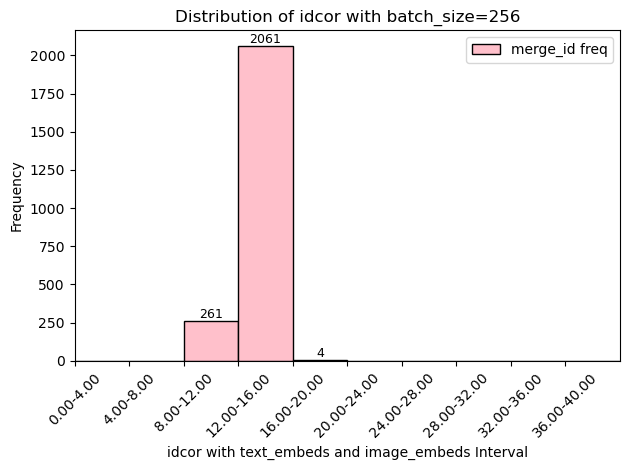

In [32]:
bin_start = 0.0  # 起始区间
bin_end = 40    # 结束区间
bin_width = 4 # 区间宽度

bins = np.arange(bin_start, bin_end + bin_width, bin_width)  # 创建一个区间范围
hist, bin_edges = np.histogram(merge_id_list, bins=bins) # 使用numpy的histogram函数来分割数据

# 绘制柱状图
plt.bar(bin_edges[:-1], hist, width=bin_width, align='edge', edgecolor='black', color='pink')

# 设置标签
plt.xlabel('idcor with text_embeds and image_embeds Interval')
plt.ylabel('Frequency')
plt.title('Distribution of idcor with batch_size=256')

xScale = [f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}' for i in range(len(bin_edges)-1)]  # 设置x轴刻度
plt.xticks(bin_edges[:-1], xScale, rotation=45)  # 将标签旋转45度，防止重叠
plt.xlim(bin_edges[0], bin_edges[-1])  # 设置x轴的范围
# 在每个柱子上方显示频率数值
for i in range(len(hist)):
    if hist[i] > 0:  # 只对频率大于0的柱子标识
        plt.text(bin_edges[i] + bin_width / 2, hist[i], str(hist[i]), ha='center', va='bottom', fontsize=9, color='black')

# 添加图例
plt.legend(['merge_id freq'], loc='upper right', fontsize=10)  # 在右上角添加图例

plt.tight_layout()  # 调整布局，防止标签被截断
plt.show()

#### 载入`qwen1.5_0.5B_clipvL14_model`在数据集`LLaVA-CC3M-Pretrain-595K`上计算抽取的`image_embeds`和`text_embeds`每个batch的corr

In [46]:
text_reps = torch.load('./representation/LLaVA-CC3M-Pretrain-595K/qwen1.5_0.5B_clipvL14_model_text.pt')
image_reps = torch.load('./representation/LLaVA-CC3M-Pretrain-595K/qwen1.5_0.5B_clipvL14_model_image.pt')
text_reps.shape, image_reps.shape

(torch.Size([595375, 768]), torch.Size([595375, 1024]))

In [47]:
batch_size = 256
# 使用 torch.split 分割张量
text_reps_batches = torch.split(text_reps, batch_size)
image_reps_batches = torch.split(image_reps, batch_size)

In [48]:
text_id_list = []
image_id_list = []
idcor_list = []
p_list = []
merge_id_list = []

# 以batch_size为一批的大小，计算text_embeds与image_embeds之间的corr
for batch, (text_embeds, image_embeds) in tqdm(enumerate(zip(text_reps_batches, image_reps_batches))):
    corr = id_correlation(text_embeds.to(torch.float32), image_embeds.to(torch.float32), 100, id_alg)
    text_id_list.append(corr['id1'])
    image_id_list.append(corr['id2'])
    idcor_list.append(corr['corr'])
    p_list.append(corr['p'])
    merge_id_list.append(corr['id'])

2326it [04:25,  8.76it/s]


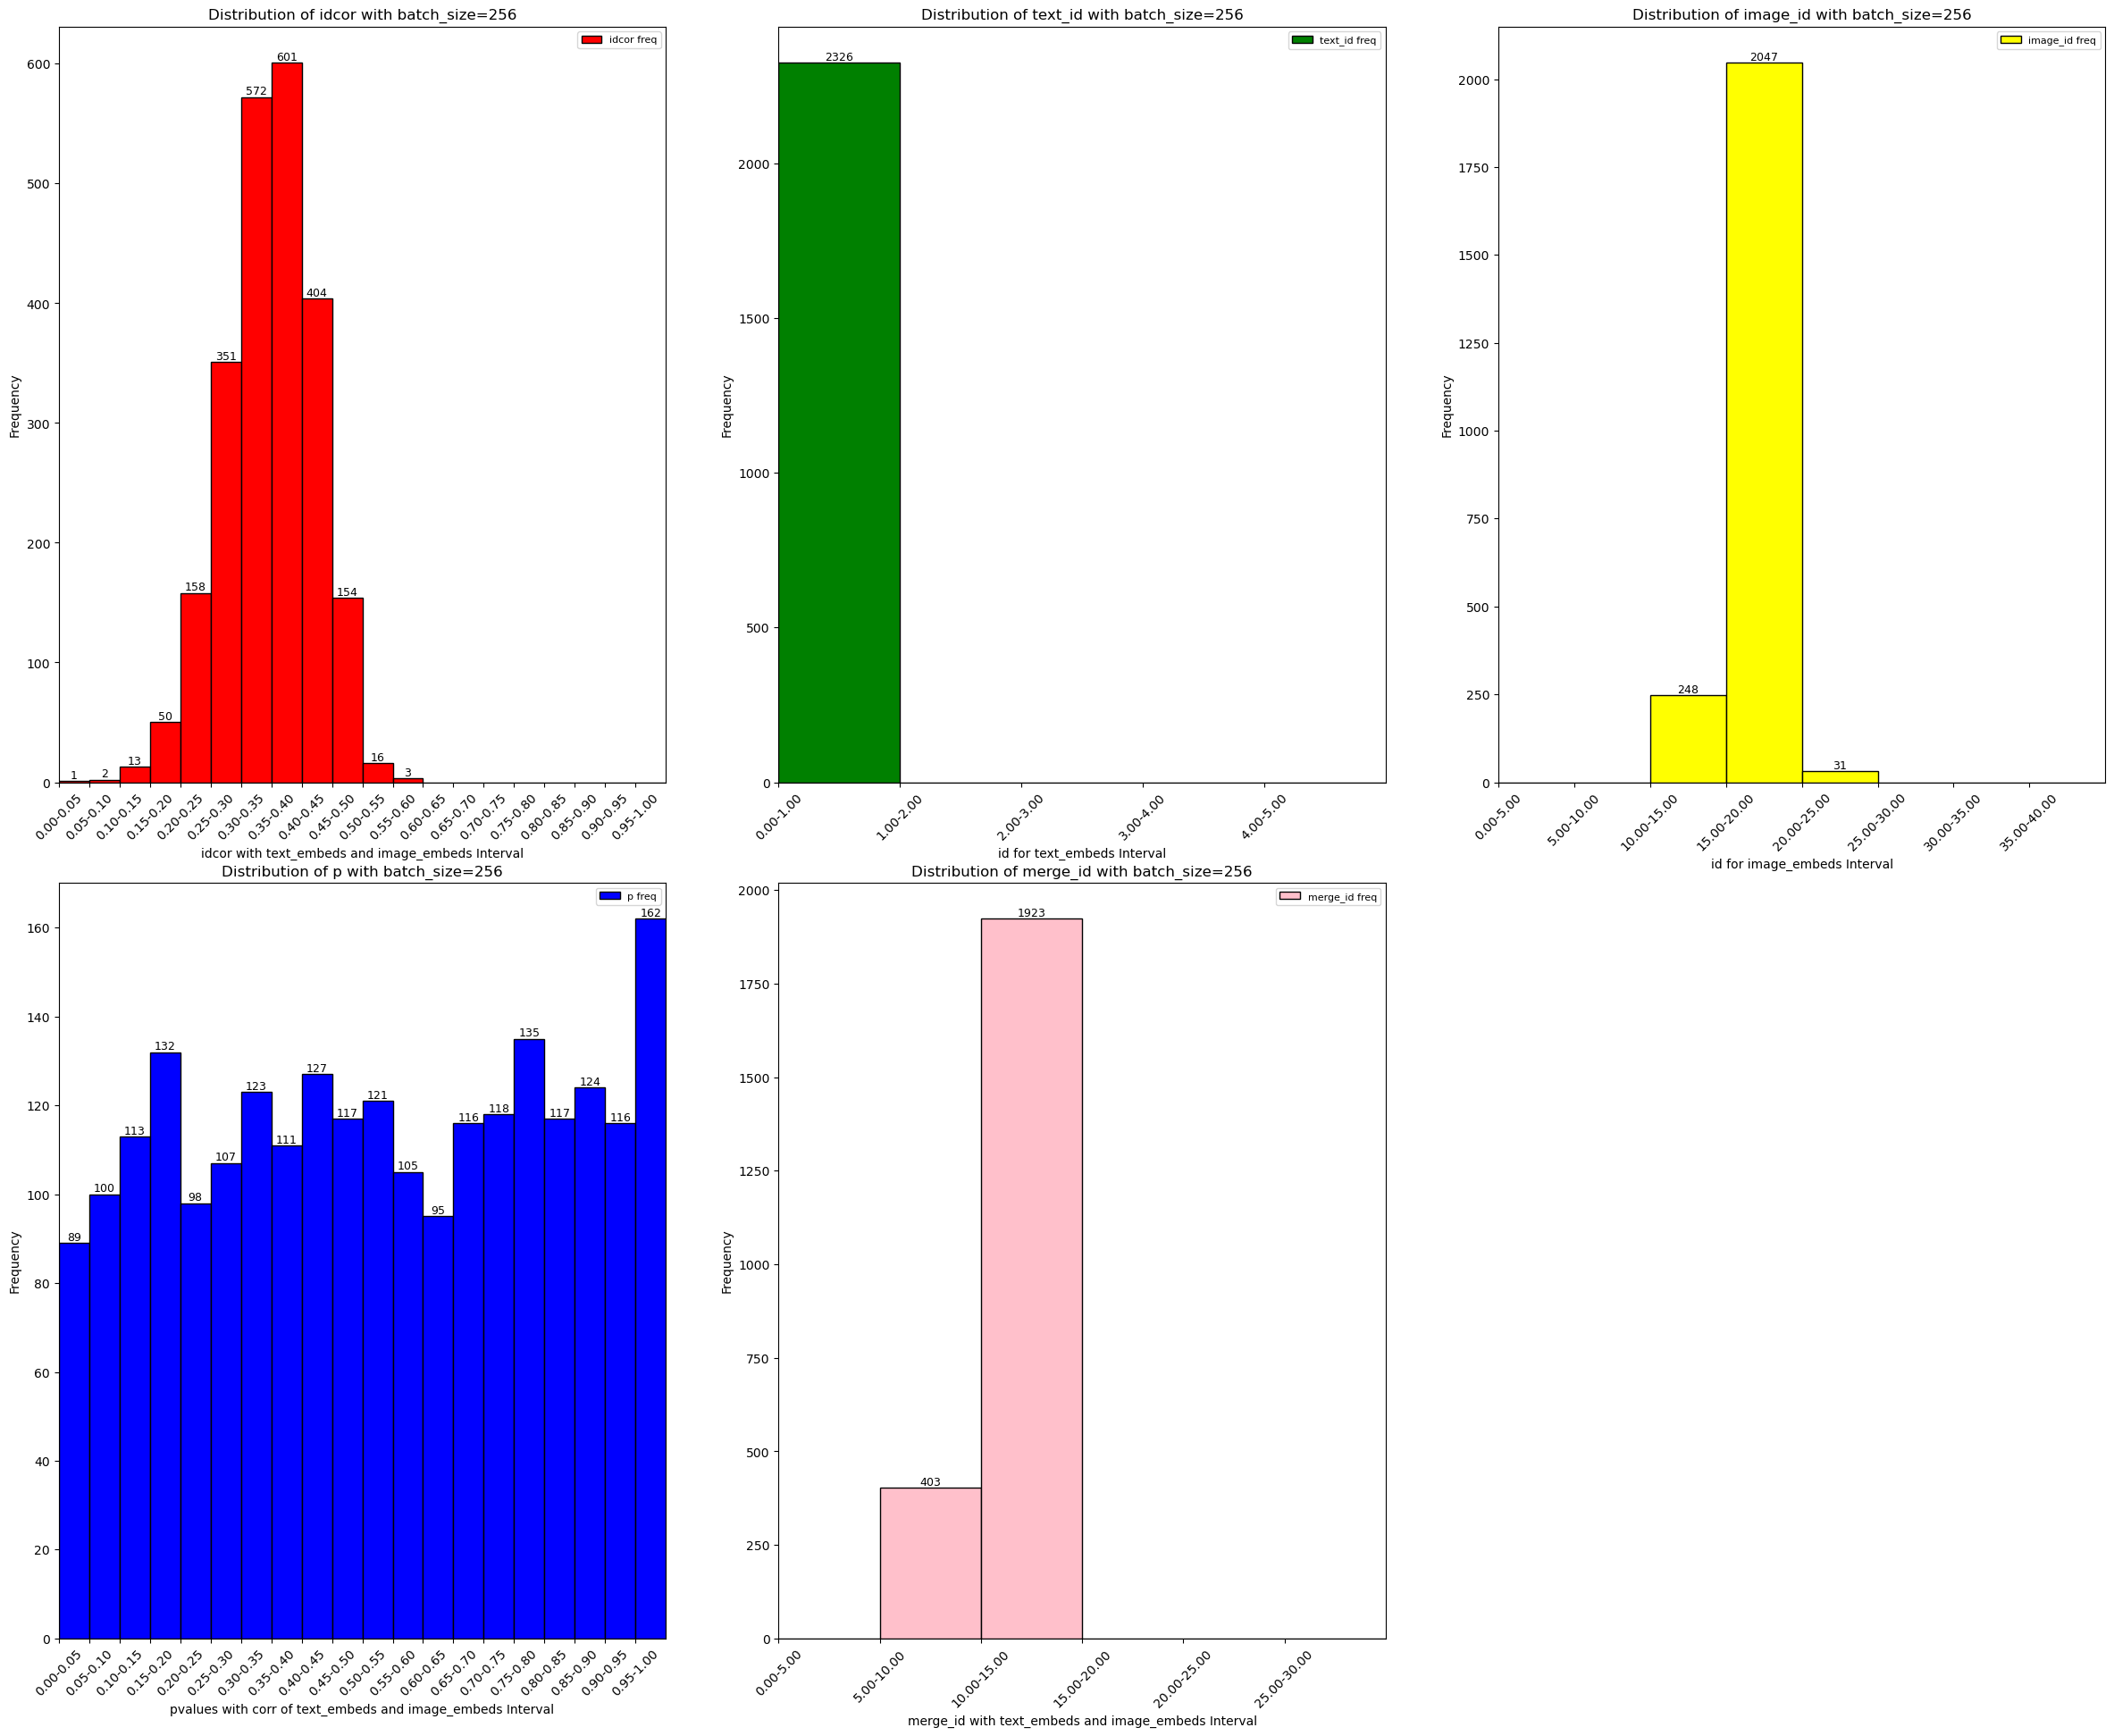

In [49]:
fig, axs = plt.subplots(2, 3, figsize=(25, 20))  # 创建一个包含 2 行 3 列子图的图形
fig.tight_layout(pad=6.0)  # 子图之间的间距

bin_start_list = [0.0, 0.0, 0.0, 0.0, 0.0]
bin_end_list = [1.0, 5.0, 40.0 ,1.0, 30.0]
bin_width_list = [0.05, 1.0, 5.0, 0.05, 5.0]
data_list = [idcor_list, text_id_list, image_id_list, p_list, merge_id_list]
name_list = ['idcor', 'text_id', 'image_id', 'p', 'merge_id']
color_list = ['red', 'green', 'yellow', 'blue', 'pink']
xlabel_list = [
    'idcor with text_embeds and image_embeds Interval',
    'id for text_embeds Interval',
    'id for image_embeds Interval',
    'pvalues with corr of text_embeds and image_embeds Interval',
    'merge_id with text_embeds and image_embeds Interval'
]

for i, ax in enumerate(axs.flat):  # axs.flat 会将二维子图展平，便于迭代
    if i < len(data_list):
        bins = np.arange(bin_start_list[i], bin_end_list[i] + bin_width_list[i], bin_width_list[i])  # 使用numpy的histogram函数来分割数据
        hist, bin_edges = np.histogram(data_list[i], bins=bins)
        
        # 绘制柱状图
        ax.bar(bin_edges[:-1], hist, width=bin_width_list[i], align='edge', edgecolor='black', color=color_list[i])
        
        # 设置标签
        ax.set_xlabel(xlabel_list[i])
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of {name_list[i]} with batch_size={batch_size}')
        
        xScale = [f'{bin_edges[j]:.2f}-{bin_edges[j+1]:.2f}' for j in range(len(bin_edges)-1)]  # 设置x轴刻度
        ax.set_xticks(bin_edges[:-1])
        ax.set_xticklabels(xScale, rotation=45)  # 将标签旋转45度，防止重叠
        ax.set_xlim(bin_edges[0], bin_edges[-1])  # 设置x轴的范围
        
        # 在每个柱子上方显示频率数值
        for j in range(len(hist)):
            if hist[j] > 0:  # 只对频率大于0的柱子标识
                ax.text(bin_edges[j] + bin_width_list[i] / 2, hist[j], str(hist[j]), ha='center', va='bottom', fontsize=9, color='black')
        
        ax.legend([f'{name_list[i]} freq'], loc='upper right', fontsize=8)  # 添加图例

fig.delaxes(axs[1, 2])  # 删除右下角的空白子图
plt.show()

#### 封装载入`text_embeds`和`image_embeds`并抽取和计算每个`batch`下`corr`的函数

In [3]:
@dataclass
class CorrelationResult:
    text_id_list: List[float]
    image_id_list: List[float]
    idcor_list: List[float]
    p_list: List[float]
    merge_id_list: List[float]

def correlation_compute(textRepPath: str, imageRepPath: str, batch_size):
    text_reps = torch.load(textRepPath)
    image_reps = torch.load(imageRepPath)
    text_reps_batches = torch.split(text_reps, batch_size)
    image_reps_batches = torch.split(image_reps, batch_size)
    text_id_list, image_id_list, idcor_list, p_list, merge_id_list = [], [], [], [], []
    
    # 以batch_size为一批的大小，计算text_embeds与image_embeds之间的corr
    for batch, (text_embeds, image_embeds) in tqdm(enumerate(zip(text_reps_batches, image_reps_batches))):
        corr = id_correlation(text_embeds.to(torch.float32), image_embeds.to(torch.float32), 100, id_alg)
        text_id_list.append(corr['id1'])
        image_id_list.append(corr['id2'])
        idcor_list.append(corr['corr'])
        p_list.append(corr['p'])
        merge_id_list.append(corr['id'])

    return CorrelationResult(
        text_id_list=text_id_list,
        image_id_list=image_id_list,
        idcor_list=idcor_list,
        p_list=p_list,
        merge_id_list=merge_id_list
    )

#### 载入`origin_qwen2.5_3B_Instruct_clipvL14_model`在数据集`LLaVA-CC3M-Pretrain-595K`上计算抽取的`image_embeds`和`text_embeds`每个batch的corr

In [7]:
batch_size = 256
textRepPath = './representation/LLaVA-CC3M-Pretrain-595K/origin_qwen2.5_3B_Instruct_clipvL14_model_text.pt'
imageRepPath = './representation/LLaVA-CC3M-Pretrain-595K/origin_qwen2.5_3B_Instruct_clipvL14_model_image.pt'
text_id_list = []
image_id_list = []
idcor_list = []
p_list = []
merge_id_list = []

corr: CorrelationResult = correlation_compute(textRepPath, imageRepPath, batch_size)
text_id_list = corr.text_id_list
image_id_list = corr.image_id_list
idcor_list = corr.idcor_list
p_list = corr.p_list
merge_id_list = corr.merge_id_list

2326it [05:33,  6.97it/s]


#### 绘制corr各项指标分布柱状图

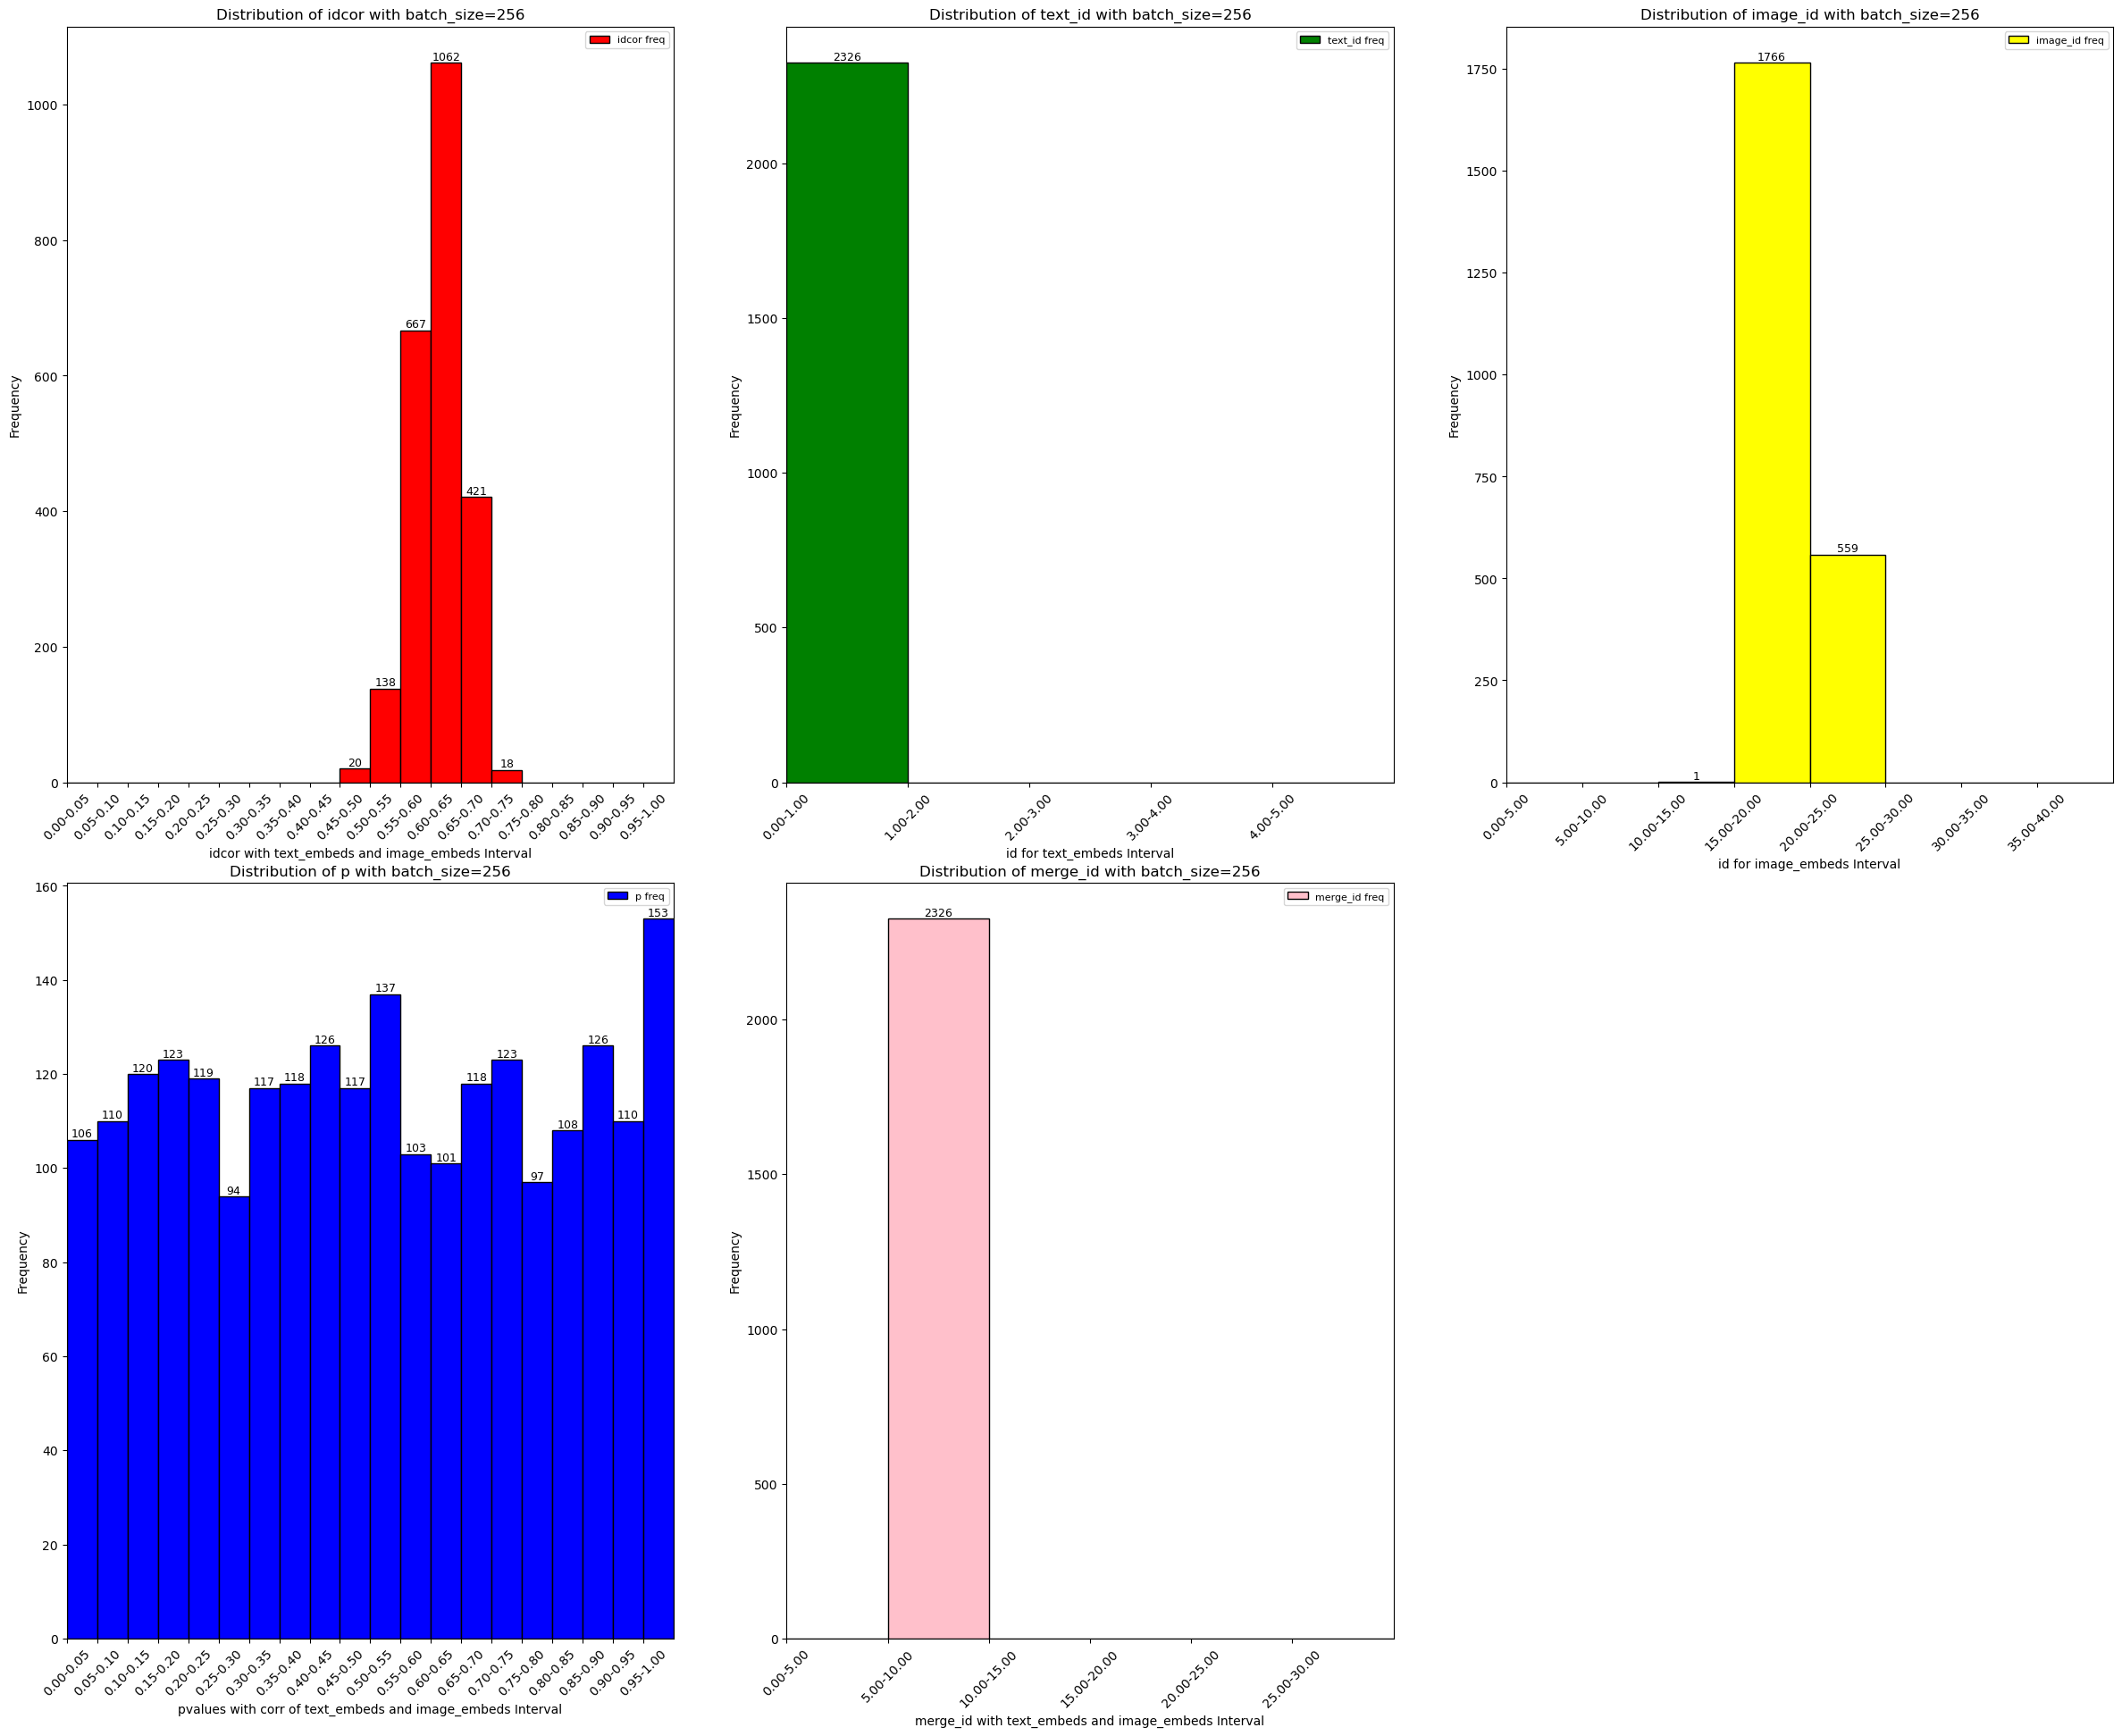

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(25, 20))  # 创建一个包含 2 行 3 列子图的图形
fig.tight_layout(pad=6.0)  # 子图之间的间距

bin_start_list = [0.0, 0.0, 0.0, 0.0, 0.0]
bin_end_list = [1.0, 5.0, 40.0 ,1.0, 30.0]
bin_width_list = [0.05, 1.0, 5.0, 0.05, 5.0]
data_list = [idcor_list, text_id_list, image_id_list, p_list, merge_id_list]
name_list = ['idcor', 'text_id', 'image_id', 'p', 'merge_id']
color_list = ['red', 'green', 'yellow', 'blue', 'pink']
xlabel_list = [
    'idcor with text_embeds and image_embeds Interval',
    'id for text_embeds Interval',
    'id for image_embeds Interval',
    'pvalues with corr of text_embeds and image_embeds Interval',
    'merge_id with text_embeds and image_embeds Interval'
]

for i, ax in enumerate(axs.flat):  # axs.flat 会将二维子图展平，便于迭代
    if i < len(data_list):
        bins = np.arange(bin_start_list[i], bin_end_list[i] + bin_width_list[i], bin_width_list[i])  # 使用numpy的histogram函数来分割数据
        hist, bin_edges = np.histogram(data_list[i], bins=bins)
        
        # 绘制柱状图
        ax.bar(bin_edges[:-1], hist, width=bin_width_list[i], align='edge', edgecolor='black', color=color_list[i])
        
        # 设置标签
        ax.set_xlabel(xlabel_list[i])
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of {name_list[i]} with batch_size={batch_size}')
        
        xScale = [f'{bin_edges[j]:.2f}-{bin_edges[j+1]:.2f}' for j in range(len(bin_edges)-1)]  # 设置x轴刻度
        ax.set_xticks(bin_edges[:-1])
        ax.set_xticklabels(xScale, rotation=45)  # 将标签旋转45度，防止重叠
        ax.set_xlim(bin_edges[0], bin_edges[-1])  # 设置x轴的范围
        
        # 在每个柱子上方显示频率数值
        for j in range(len(hist)):
            if hist[j] > 0:  # 只对频率大于0的柱子标识
                ax.text(bin_edges[j] + bin_width_list[i] / 2, hist[j], str(hist[j]), ha='center', va='bottom', fontsize=9, color='black')
        
        ax.legend([f'{name_list[i]} freq'], loc='upper right', fontsize=8)  # 添加图例

fig.delaxes(axs[1, 2])  # 删除右下角的空白子图
plt.show()

#### 载入`purestage1_qwen2.5_3B_Instruct_clipvL14_model`在数据集`LLaVA-CC3M-Pretrain-595K`上计算抽取的`image_embeds`和`text_embeds`每个batch的corr

In [4]:
batch_size = 256
textRepPath = './representation/LLaVA-CC3M-Pretrain-595K/purestage1_qwen2.5_3B_Instruct_clipvL14_model_text.pt'
imageRepPath = './representation/LLaVA-CC3M-Pretrain-595K/purestage1_qwen2.5_3B_Instruct_clipvL14_model_image.pt'
text_id_list = []
image_id_list = []
idcor_list = []
p_list = []
merge_id_list = []

corr: CorrelationResult = correlation_compute(textRepPath, imageRepPath, batch_size)
text_id_list = corr.text_id_list
image_id_list = corr.image_id_list
idcor_list = corr.idcor_list
p_list = corr.p_list
merge_id_list = corr.merge_id_list

2326it [05:46,  6.71it/s]


#### 绘制corr各项指标分布柱状图

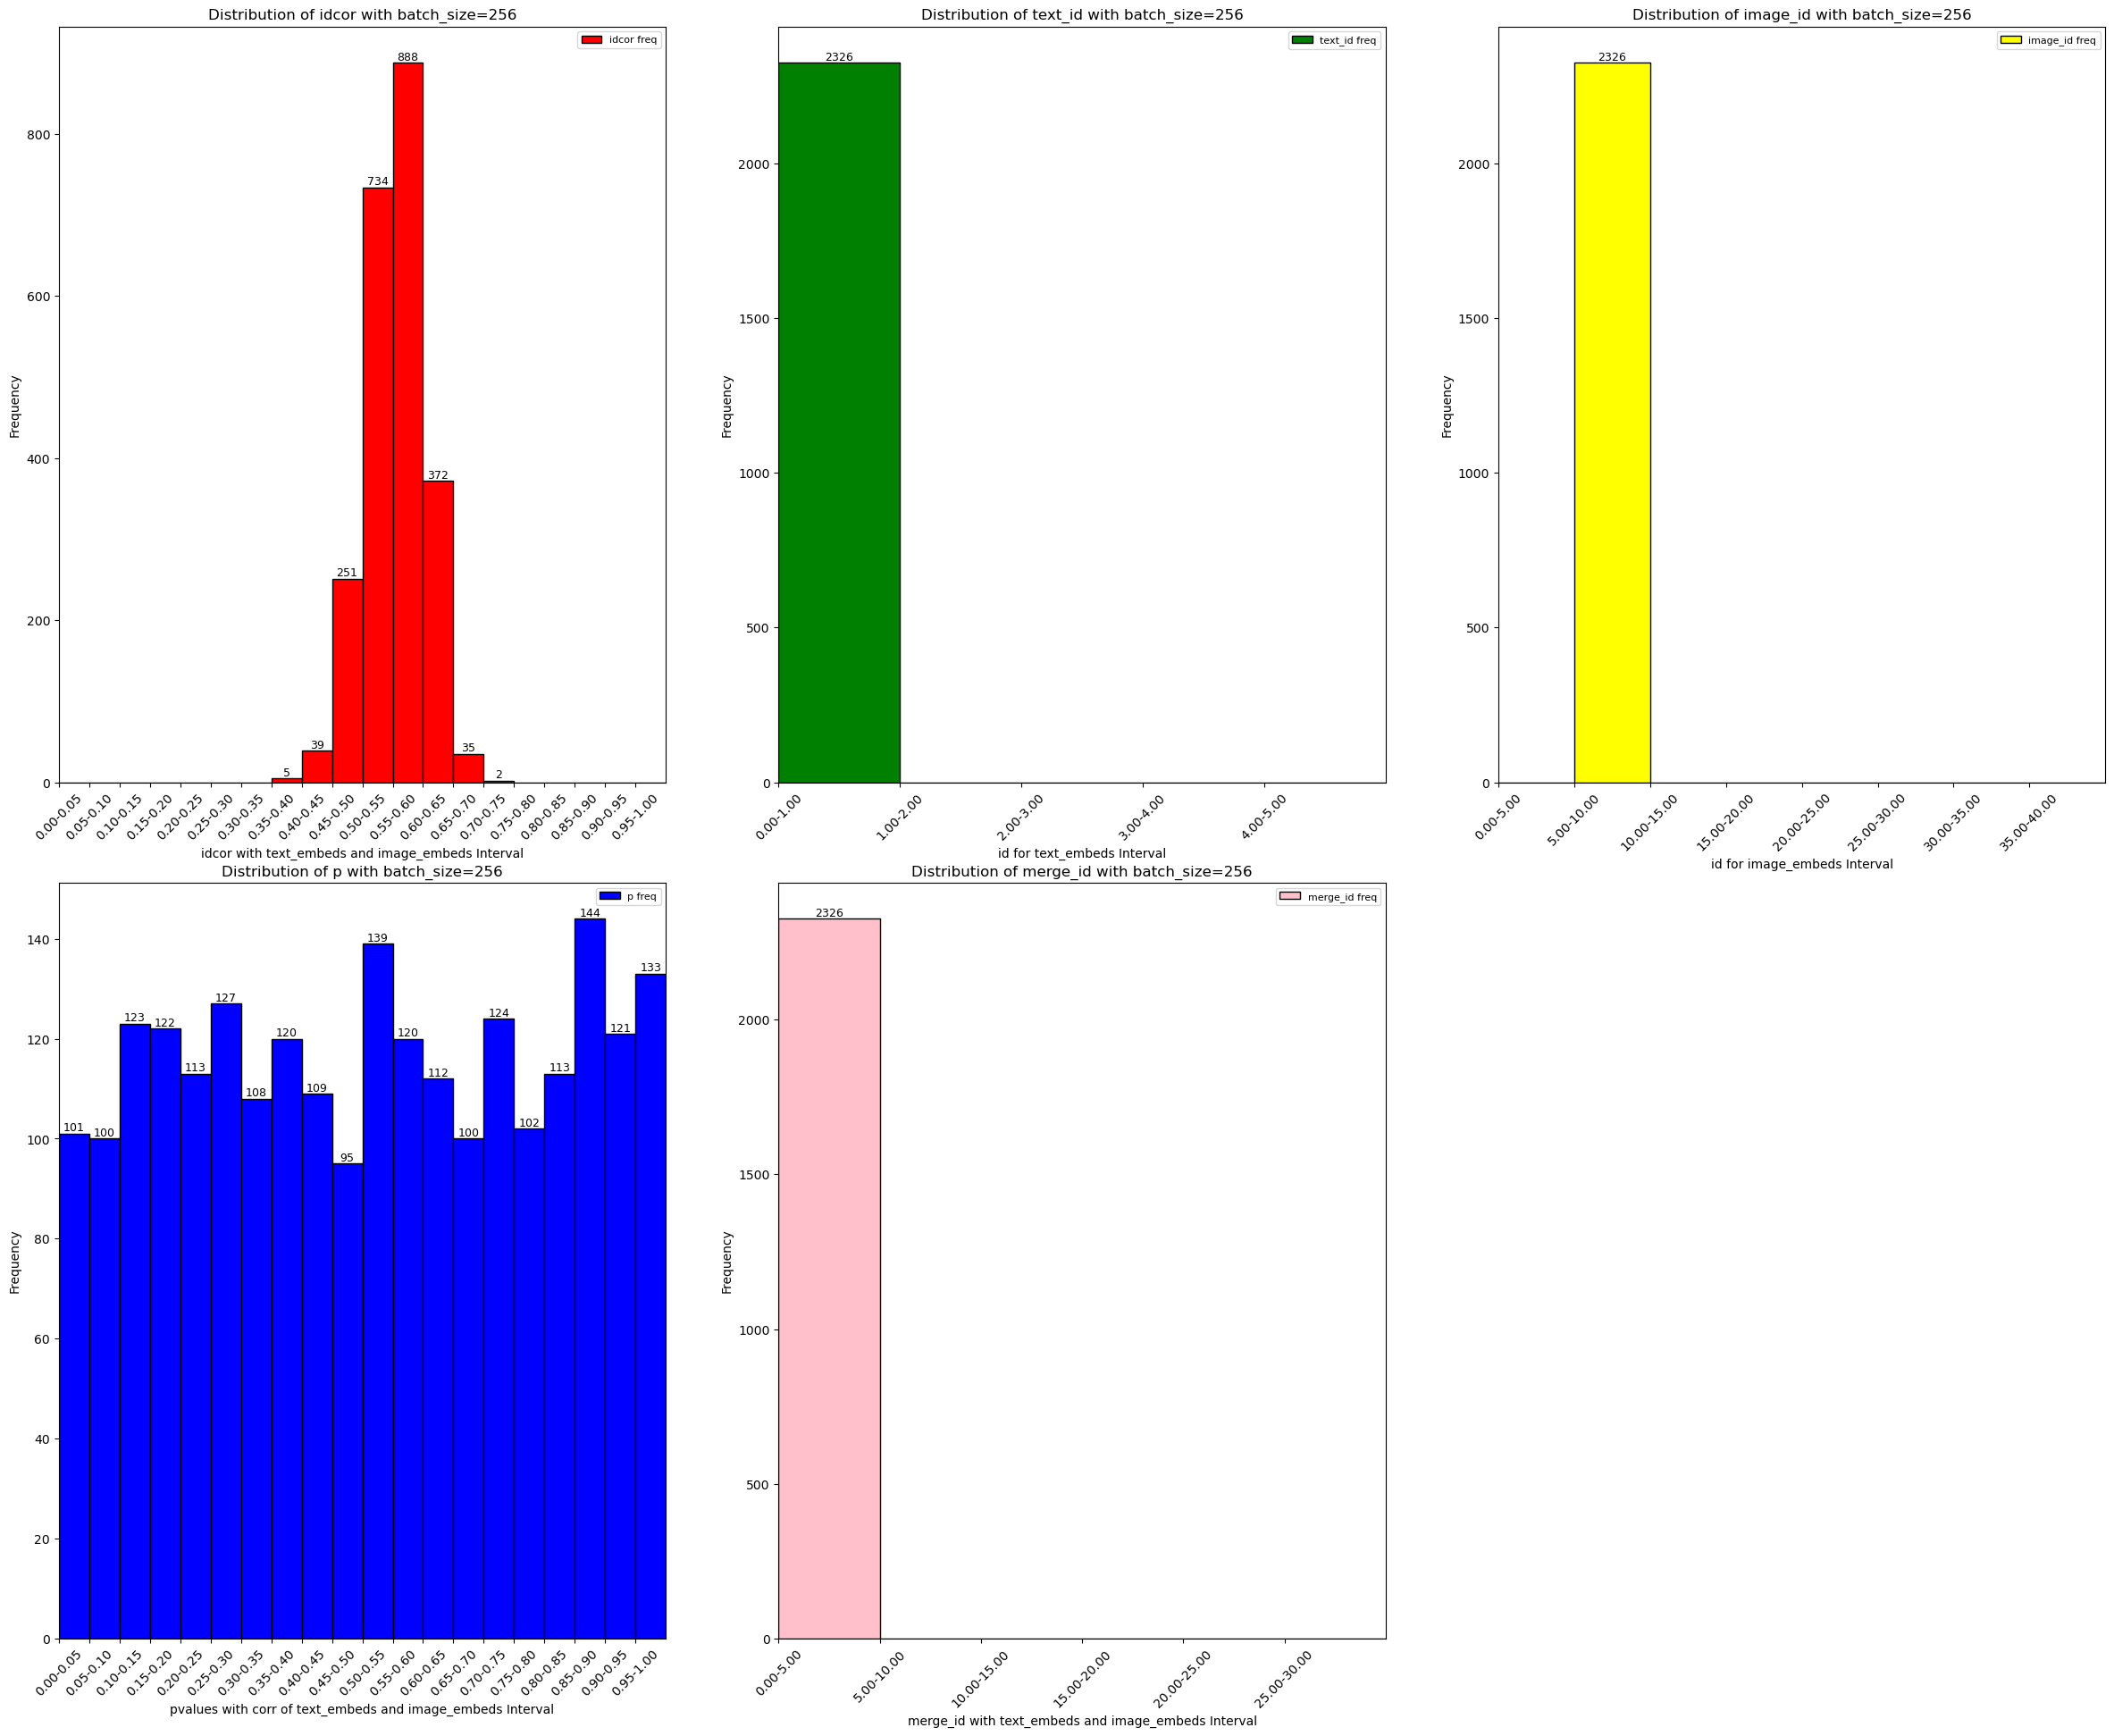

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(25, 20))  # 创建一个包含 2 行 3 列子图的图形
fig.tight_layout(pad=6.0)  # 子图之间的间距

bin_start_list = [0.0, 0.0, 0.0, 0.0, 0.0]
bin_end_list = [1.0, 5.0, 40.0 ,1.0, 30.0]
bin_width_list = [0.05, 1.0, 5.0, 0.05, 5.0]
data_list = [idcor_list, text_id_list, image_id_list, p_list, merge_id_list]
name_list = ['idcor', 'text_id', 'image_id', 'p', 'merge_id']
color_list = ['red', 'green', 'yellow', 'blue', 'pink']
xlabel_list = [
    'idcor with text_embeds and image_embeds Interval',
    'id for text_embeds Interval',
    'id for image_embeds Interval',
    'pvalues with corr of text_embeds and image_embeds Interval',
    'merge_id with text_embeds and image_embeds Interval'
]

for i, ax in enumerate(axs.flat):  # axs.flat 会将二维子图展平，便于迭代
    if i < len(data_list):
        bins = np.arange(bin_start_list[i], bin_end_list[i] + bin_width_list[i], bin_width_list[i])  # 使用numpy的histogram函数来分割数据
        hist, bin_edges = np.histogram(data_list[i], bins=bins)
        
        # 绘制柱状图
        ax.bar(bin_edges[:-1], hist, width=bin_width_list[i], align='edge', edgecolor='black', color=color_list[i])
        
        # 设置标签
        ax.set_xlabel(xlabel_list[i])
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of {name_list[i]} with batch_size={batch_size}')
        
        xScale = [f'{bin_edges[j]:.2f}-{bin_edges[j+1]:.2f}' for j in range(len(bin_edges)-1)]  # 设置x轴刻度
        ax.set_xticks(bin_edges[:-1])
        ax.set_xticklabels(xScale, rotation=45)  # 将标签旋转45度，防止重叠
        ax.set_xlim(bin_edges[0], bin_edges[-1])  # 设置x轴的范围
        
        # 在每个柱子上方显示频率数值
        for j in range(len(hist)):
            if hist[j] > 0:  # 只对频率大于0的柱子标识
                ax.text(bin_edges[j] + bin_width_list[i] / 2, hist[j], str(hist[j]), ha='center', va='bottom', fontsize=9, color='black')
        
        ax.legend([f'{name_list[i]} freq'], loc='upper right', fontsize=8)  # 添加图例

fig.delaxes(axs[1, 2])  # 删除右下角的空白子图
plt.show()